# Comparing photometric fluxes and model spectra

In this tutorial, we will compare the photometric fluxes of the brown dwarf companion PZ Tel B with a synthetic spectrum from the ATMO grid.

## Initiating *species*

We start by importing *species*.

In [1]:
from species import SpeciesInit
from species.data.database import Database
from species.read.read_model import ReadModel
from species.plot.plot_spectrum import plot_spectrum
from species.util.fit_util import get_residuals, multi_photometry

And initiating the workflow with the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit) class. This will create the configuration file and the HDF5 database.

In [2]:
SpeciesInit()

species

Version: 0.9.1.dev64+g1d42feb.d20250418
Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


## Adding model spectra

We create now a [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object which is used for importing various data into the database.

In [3]:
database = Database()

The spectra of ATMO are downloaded and added to the database with the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This requires sufficient disk storage in the *data_folder* that is set in the configuration file. The full ATMO grid is downloaded but the `teff_range` parameter can be used to only import a certain $T_\mathrm{eff}$ range into the database.

In [4]:
database.add_model('atmo', teff_range=(2500., 3000.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: atmo
Model name: ATMO



100%|█████████████████████████████████████| 21.1M/21.1M [00:00<00:00, 40.1GB/s]



Unpacking 42/231 model spectra from ATMO (21 MB)... [DONE]

Please cite Phillips et al. (2020) when using ATMO in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P

Wavelength range (um) = 0.2 - 2000
Sampling (lambda/d_lambda) = 1000
Teff range (K) = 2500.0 - 3000.0

Adding ATMO model spectra... data/atmo/atmo_teff_3000_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2500. 2600. 2700. 2800. 2900. 3000.]
   - log(g) = [2.5 3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 6
   - logg: 7

Number of stored grid points: 42
Number of interpolated grid points: 0
Number of missing grid points: 0


## Adding companion data

Next, we add the parallax and magnitudes of PZ Tel B to the database with the [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) method. This will automatically download the required filter profiles and a flux-calibrated spectrum of Vega. These are used to convert the magnitudes into fluxes.

In [5]:
database.add_companion('PZ Tel B', verbose=False)

Add companion: ['PZ Tel B']


100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 322MB/s]


Adding spectrum: Vega
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract


Alternatively, the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) can be used for manually adding magnitudes and spectra of an individual object. Before continuing, let's check the content of the database.

In [6]:
database.list_content()


---------------------
List database content
---------------------

- filters: <HDF5 group "/filters" (2 members)>
	- Gemini: <HDF5 group "/filters/Gemini" (2 members)>
		- NICI.ED286: <HDF5 dataset "NICI.ED286": shape (387, 2), type "<f8">
			- det_type: energy
			- det_type = energy
		- NIRI.H2S1v2-1-G0220: <HDF5 dataset "NIRI.H2S1v2-1-G0220": shape (129, 2), type "<f8">
			- det_type: energy
			- det_type = energy
	- Paranal: <HDF5 group "/filters/Paranal" (12 members)>
		- NACO.H: <HDF5 dataset "NACO.H": shape (23, 2), type "<f8">
			- det_type: energy
			- det_type = energy
		- NACO.J: <HDF5 dataset "NACO.J": shape (20, 2), type "<f8">
			- det_type: energy
			- det_type = energy
		- NACO.Ks: <HDF5 dataset "NACO.Ks": shape (27, 2), type "<f8">
			- det_type: energy
			- det_type = energy
		- NACO.Lp: <HDF5 dataset "NACO.Lp": shape (31, 2), type "<f8">
			- det_type: energy
			- det_type = energy
		- NACO.Mp: <HDF5 dataset "NACO.Mp": shape (18, 2), type "<f8">
			- det_type: energy

We see the various groups, subgroups, datasets, and attributes that are stored in the HDF5 database.

## Reading model spectra

Model spectra are read from the database by first creating an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel). The model name and optionally a wavelength range are provided as arguments.

In [7]:
readmodel = ReadModel('atmo', wavel_range=(0.5, 10.))

Before extracting a spectrum, let's check which parameters are required for the ATMO model spectra.

In [8]:
readmodel.get_parameters()

['teff', 'logg']

And also the parameter boundaries of the grid that is stored in the database.

In [9]:
readmodel.get_bounds()

{'teff': (np.float64(2500.0), np.float64(3000.0)),
 'logg': (np.float64(2.5), np.float64(5.5))}

The parameters are provided in a dictionary for which we have to make sure that chose values are within the grid boundaries. The radius ($R_\mathrm{J}$) and distance (pc) will scale the emitted spectrum to the observer. Without these values, the spectrum fluxes are provided at the surface of the atmosphere.

In [10]:
model_param = {'teff': 2900., 'logg': 4.5, 'radius': 2.2, 'distance': 47.13}

We now use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) to linearly interpolate the grid of spectra and store the extracted spectrum in a `ModelBox`. The spectrum is smoothed to a spectral resolution of $R = 100$.

In [11]:
modelbox = readmodel.get_model(model_param, spec_res=100., smooth=True)

## Reading companion data

The photometric data of PZ Tel B are also read from the database and stored in an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

In [12]:
objectbox = database.get_object(object_name='PZ Tel B')


----------
Get object
----------

Object name: PZ Tel B
Include photometry: True
Include spectra: True


## Synthetic photometry for all filters

For comparison, we create synthetic photometry from the extracted ATMO spectrum for all filters of PZ Tel B. The synthetic fluxes are stored in a [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox).

In [13]:
synphot_box = multi_photometry(datatype='model',
                               spectrum='atmo',
                               filters=objectbox.filters,
                               parameters=model_param)


--------------------------
Calculate multi-photometry
--------------------------

Data type: model
Spectrum name: atmo

Parameters:
   - teff = 2900.00
   - logg = 4.50
   - radius = 2.20
   - distance = 47.13
   - log_lum_atm = -2.49
   - log_lum = -2.49
   - mass = 61.75

Magnitudes:
   - Gemini/NICI.ED286 = 11.82
   - Gemini/NIRI.H2S1v2-1-G0220 = 11.32
   - Paranal/NACO.H = 11.79
   - Paranal/NACO.J = 12.37
   - Paranal/NACO.Ks = 11.52
   - Paranal/NACO.Lp = 10.97
   - Paranal/NACO.Mp = 11.04
   - Paranal/NACO.NB405 = 10.89
   - Paranal/SPHERE.IRDIS_D_H23_2 = 11.82
   - Paranal/SPHERE.IRDIS_D_H23_3 = 11.58
   - Paranal/SPHERE.IRDIS_D_K12_1 = 11.59
   - Paranal/SPHERE.IRDIS_D_K12_2 = 11.33
   - Paranal/SPHERE.ZIMPOL_I_PRIM = 14.44
   - Paranal/SPHERE.ZIMPOL_R_PRIM = 16.96

Fluxes (W m-2 um-1):
   - Gemini/NICI.ED286 = 2.40e-14
   - Gemini/NIRI.H2S1v2-1-G0220 = 1.11e-14
   - Paranal/NACO.H = 2.20e-14
   - Paranal/NACO.J = 3.37e-14
   - Paranal/NACO.Ks = 1.11e-14
   - Paranal/NACO.Lp 

## Opening Box objects

The [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method can be used to view the content of any [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object. For example, the [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) contains several attributes, including the wavelengths and fluxes.

In [14]:
modelbox.open_box()

Opening ModelBox...
model = atmo
type = None
wavelength = [ 0.49082927  0.49131575  0.49180271 ... 10.16291896 10.17299187
 10.18307476]
flux = [4.32979056e-15 4.44278351e-15 4.54287819e-15 ... 5.50293177e-17
 5.49825601e-17 5.49507556e-17]
parameters = {'teff': 2900.0, 'logg': 4.5, 'radius': 2.2, 'distance': 47.13, 'log_lum_atm': np.float64(-2.487198081818381), 'log_lum': np.float64(-2.487198081818381), 'mass': np.float64(61.74898371650208)}
quantity = flux
contribution = None
bol_flux = None
spec_res = 100.0
extra_out = None


Similarly, an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) contains a dictionary with the magnitudes and a dictionary with the fluxes.

In [15]:
objectbox.open_box()

Opening ObjectBox...
name = PZ Tel B
filters = ['Gemini/NICI.ED286', 'Gemini/NIRI.H2S1v2-1-G0220', 'Paranal/NACO.H', 'Paranal/NACO.J', 'Paranal/NACO.Ks', 'Paranal/NACO.Lp', 'Paranal/NACO.Mp', 'Paranal/NACO.NB405', 'Paranal/SPHERE.IRDIS_D_H23_2', 'Paranal/SPHERE.IRDIS_D_H23_3', 'Paranal/SPHERE.IRDIS_D_K12_1', 'Paranal/SPHERE.IRDIS_D_K12_2', 'Paranal/SPHERE.ZIMPOL_I_PRIM', 'Paranal/SPHERE.ZIMPOL_R_PRIM']
mean_wavel = {'Gemini/NICI.ED286': np.float64(1.5841803431418238), 'Gemini/NIRI.H2S1v2-1-G0220': np.float64(2.2447142746110718), 'Paranal/NACO.H': np.float64(1.6588090664617747), 'Paranal/NACO.J': np.float64(1.265099894847529), 'Paranal/NACO.Ks': np.float64(2.144954491491888), 'Paranal/NACO.Lp': np.float64(3.8050282724280526), 'Paranal/NACO.Mp': np.float64(4.780970919324577), 'Paranal/NACO.NB405': np.float64(4.055862923806052), 'Paranal/SPHERE.IRDIS_D_H23_2': np.float64(1.5863509078883227), 'Paranal/SPHERE.IRDIS_D_H23_3': np.float64(1.6661442175885708), 'Paranal/SPHERE.IRDIS_D_K12_1': np

The attributes in a [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object can be extracted for further analysis or creating plots. For example, to extract the array with wavelengths from the [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox):

In [16]:
modelbox.wavelength

array([ 0.49082927,  0.49131575,  0.49180271, ..., 10.16291896,
       10.17299187, 10.18307476], shape=(3062,))

## Plotting model spectrum and photometric fluxes

Finally, we will combine the model spectrum and the photometric fluxes in a plot with [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). A list with [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects is provided as an argument of `boxes`. These are interpreted accordingly by the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function. Also a list with filter names can be provided as argument of `filters` to show the filter profiles. The [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is provided as arguments of `residuals`. Finally, the optional argument of `plot_kwargs` contains a list with optional dictionaries to tune the visualization of the plotted data. The number of items in the list of `plot_kwargs` should be equal to the number of items in the list of `boxes`. For the [SynphotBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.SynphotBox), we can set the item in `plot_kwargs` to `None` such that the marker design is based on the data from [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox).

The blue squares are the photometric fluxes of PZ Tel B and the open squares are the synthetic photometry computed from the model spectrum. The residuals are shown relative to the uncertainties on the fluxes.


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ObjectBox
   - SynphotBox

Object type: planet
Quantity: flux density
Units: ('um', 'erg s-1 cm-2 Hz-1')
Filter profiles: ['Gemini/NICI.ED286', 'Gemini/NIRI.H2S1v2-1-G0220', 'Paranal/NACO.H', 'Paranal/NACO.J', 'Paranal/NACO.Ks', 'Paranal/NACO.Lp', 'Paranal/NACO.Mp', 'Paranal/NACO.NB405', 'Paranal/SPHERE.IRDIS_D_H23_2', 'Paranal/SPHERE.IRDIS_D_H23_3', 'Paranal/SPHERE.IRDIS_D_K12_1', 'Paranal/SPHERE.IRDIS_D_K12_2', 'Paranal/SPHERE.ZIMPOL_I_PRIM', 'Paranal/SPHERE.ZIMPOL_R_PRIM']

Figure size: (5, 3)
Legend parameters: None
Include model name: False


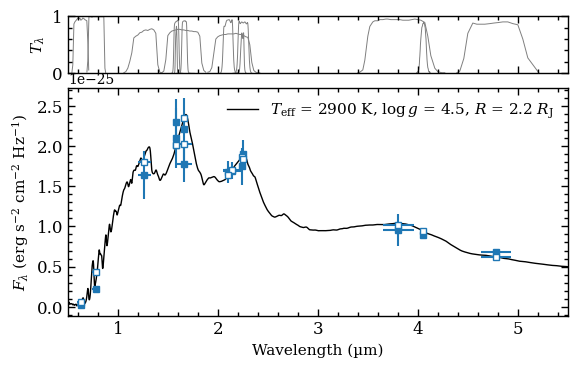

In [17]:
fig = plot_spectrum(boxes=[modelbox, objectbox, synphot_box],
                    filters=objectbox.filters,
                    residuals=None,
                    plot_kwargs=[{'ls': '-', 'lw': 1., 'color': 'black'},
                                 {'Gemini/NICI.ED286': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Gemini/NIRI.H2S1v2-1-G0220': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.H': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.J': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.Ks': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.Lp': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.Mp': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/NACO.NB405': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.IRDIS_D_H23_2': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.IRDIS_D_H23_3': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.IRDIS_D_K12_1': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.IRDIS_D_K12_2': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.ZIMPOL_I_PRIM': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'},
                                  'Paranal/SPHERE.ZIMPOL_R_PRIM': {'marker': 's', 'ms': 4., 'color': 'tab:blue', 'ls': 'none'}},
                                  None],
                    xlim=(0.5, 5.5),
                    legend={'loc': 'upper right', 'frameon': False, 'fontsize': 11.},
                    units=('um', 'erg s-1 cm-2 Hz-1'),
                    figsize=(5, 3),
                    output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [18]:
fig.axes

[<Axes: xlabel='Wavelength (µm)', ylabel='$F_\\lambda$ (erg s$^{-2}$ cm$^{-2}$ Hz$^{-1}$)'>,
 <Axes: ylabel='$T_\\lambda$'>]